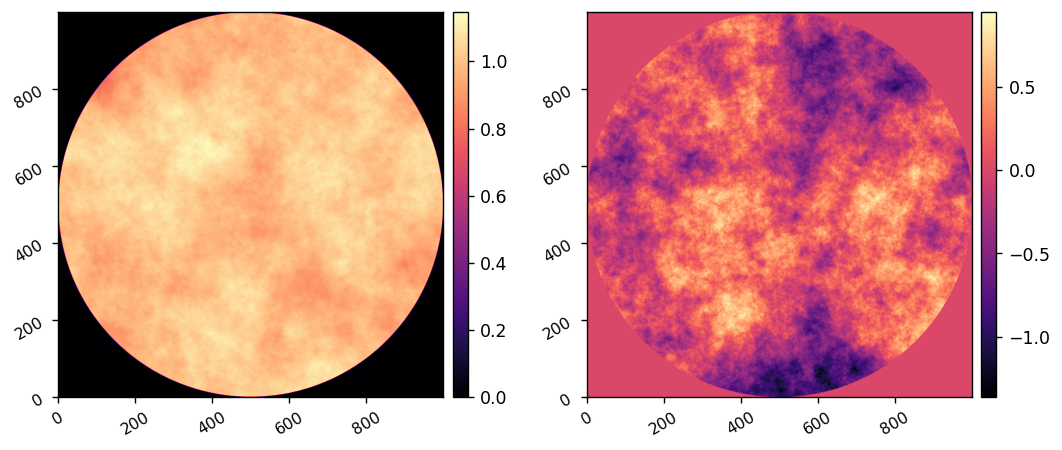

In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoob_fraunhofer as scoob
import scoobpsf.utils as utils
import scoobpsf.dm as dm

import lina

wavelength_c = 633*u.nm
pupil_diam = 10*u.mm

reload(utils)
wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_phs = utils.load_fits('example_wfe_phs.fits')
WFE = wfe_amp * xp.exp(1j*wfe_phs)
imshow2(wfe_amp, wfe_phs)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


(1000, 1000)


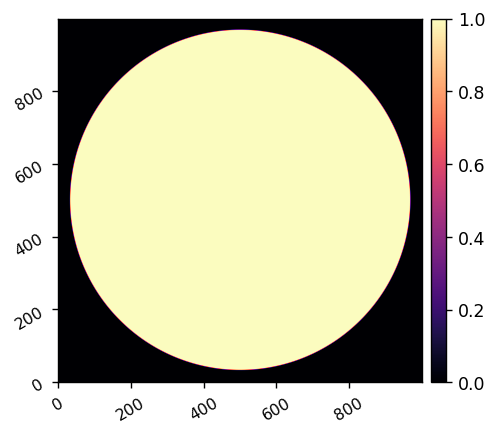

(2048, 2048)


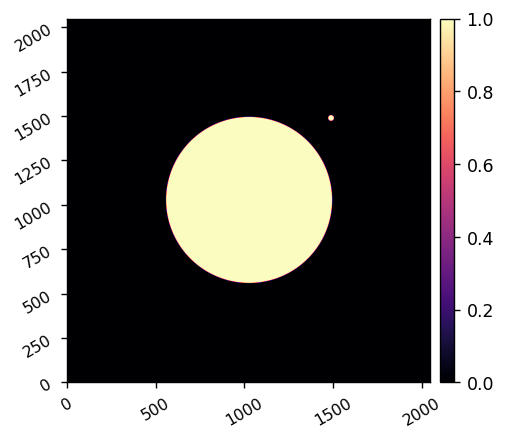

(2048, 2048)


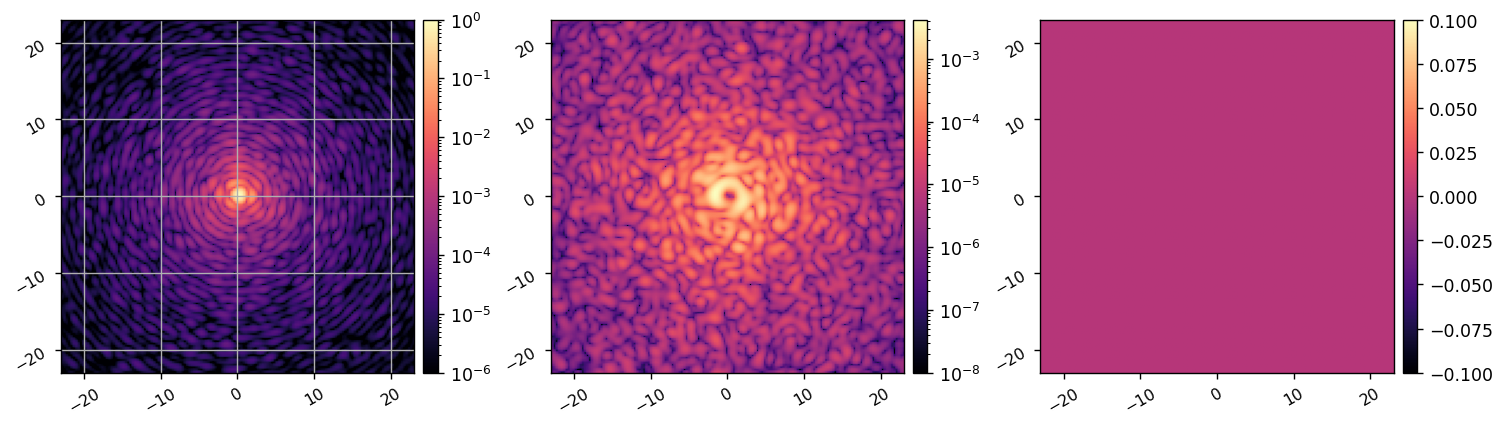

In [7]:
import copy
reload(scoob)
M = scoob.single()
M.setattr('WFE', WFE)

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

M.setattr('use_vortex', True)
M.use_scc(False)
imshow1(M.LYOT)
coro_im = M.snap()

M.use_scc()
imshow1(M.LYOT)
mod_coro_im = M.snap()

imshow3(ref_psf/M.Imax_ref, coro_im, coro_im - mod_coro_im, 
        lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=M.psf_pixelscale_lamD, grid=True, )

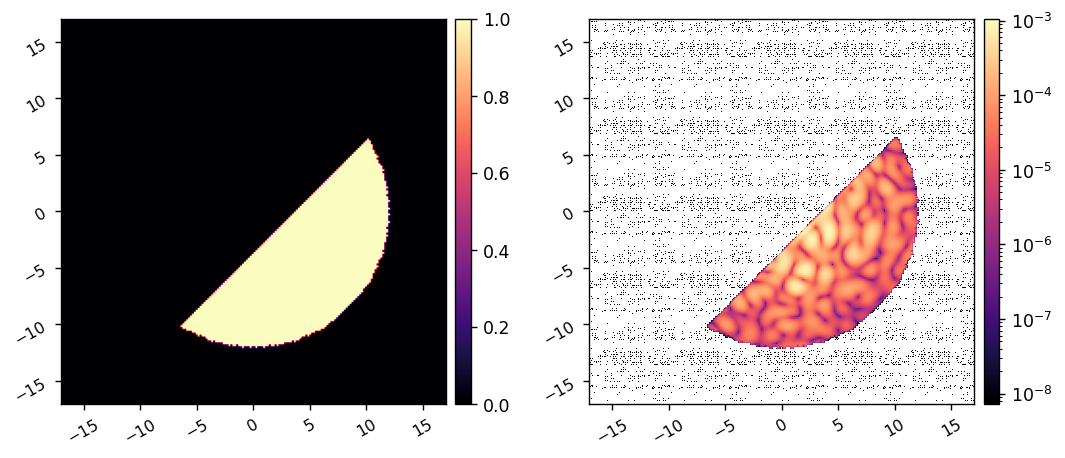

In [8]:
reload(lina.utils)
control_mask = lina.utils.create_annular_focal_plane_mask(model, 2.5, 12, 2.5, rotation=45)
imshow2(control_mask, scc_im*control_mask, lognorm2=True, pxscl=model.psf_pixelscale_lamD)



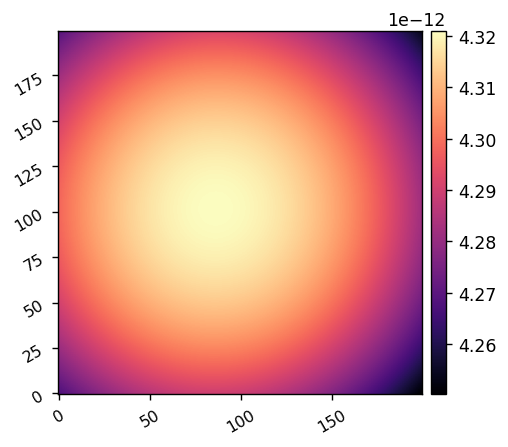

In [8]:
model.reset_dm()
model.block_lyot()
scc_ref_image = model.snap()
model.block_lyot(False)
imshow1(scc_ref_image)

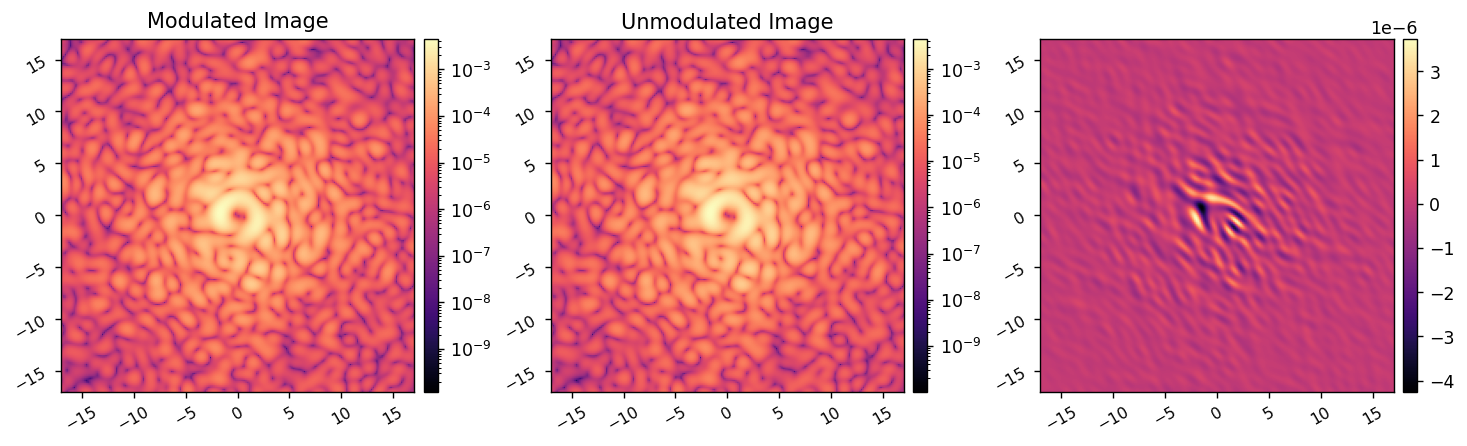

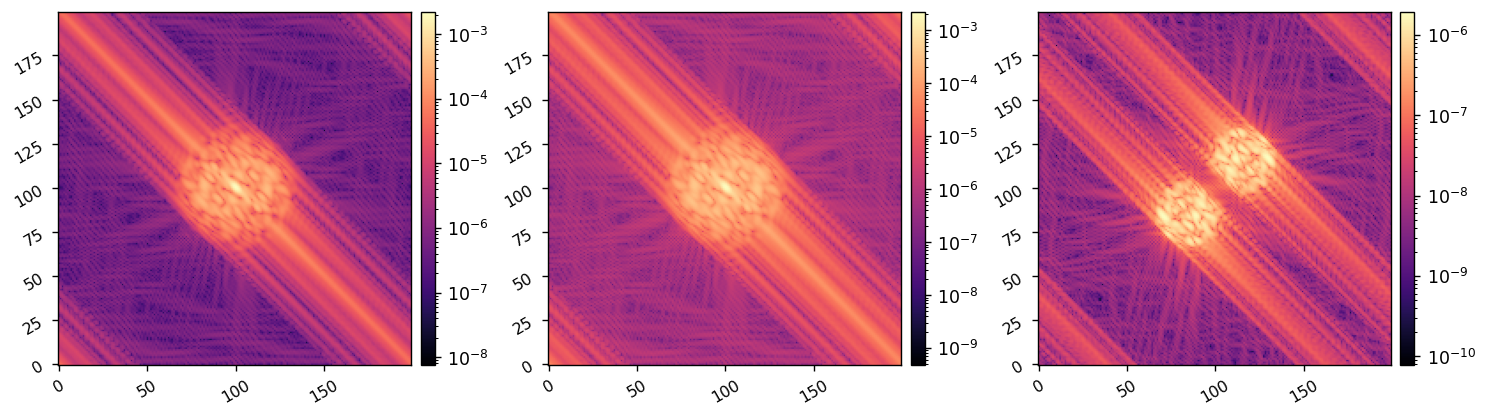

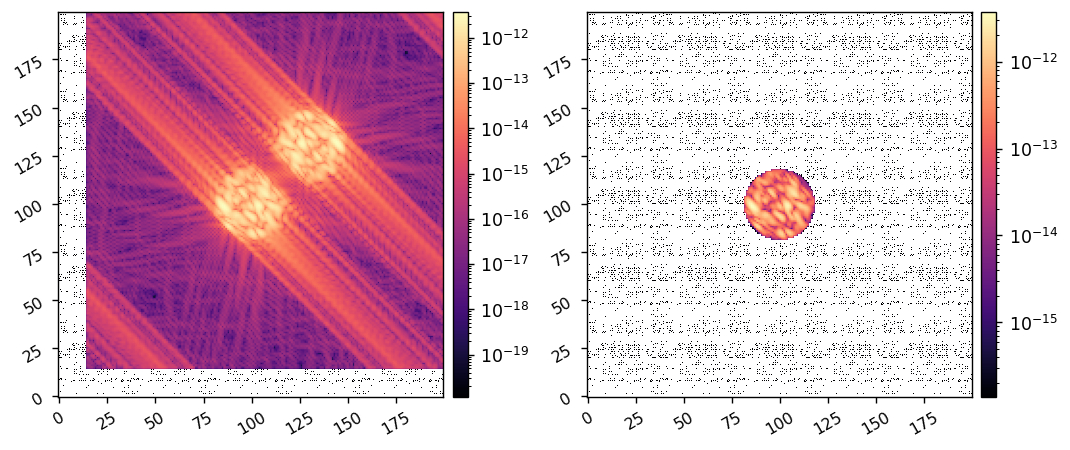

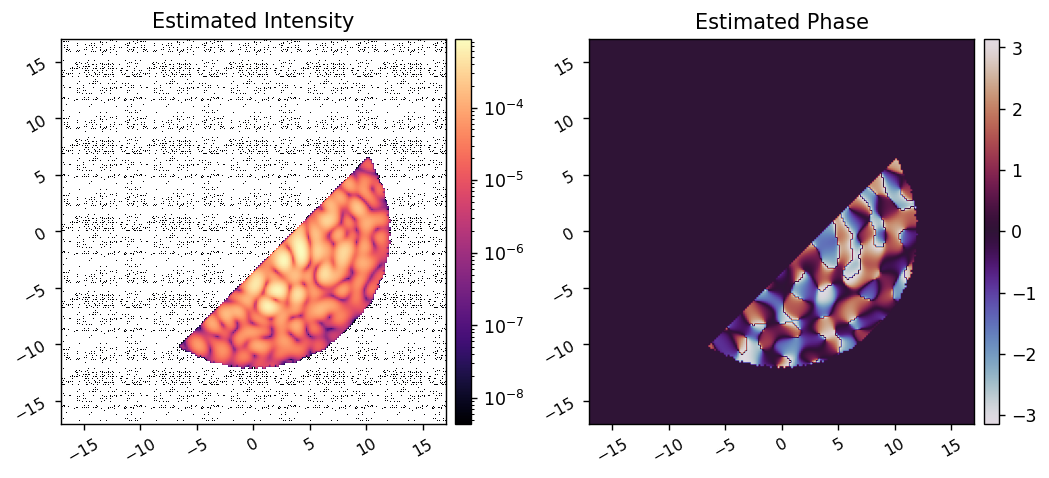

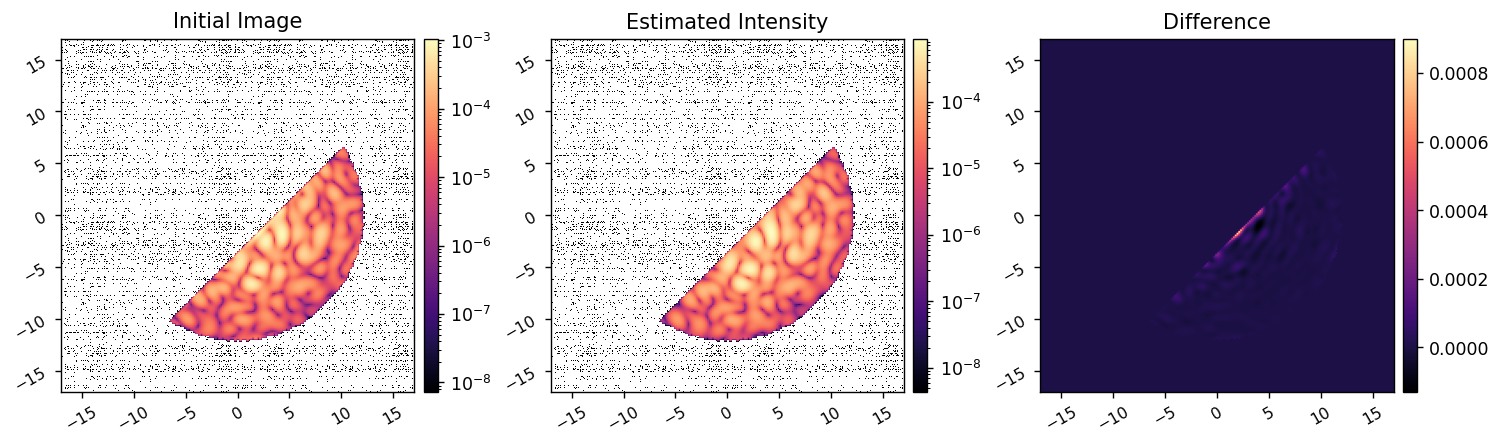

In [9]:
reload(lina.scc)
est_fun = lina.scc.estimate_coherent_mod
est_params = {
    'r_npix':18, 
    'shift':(15,15), 
    # 'scc_ref_image':scc_ref_image,
    'dark_mask':control_mask,
    'plot':True,
}

model.reset_dm()
E_est = est_fun(model, **est_params)
diff = scc_im*control_mask - xp.abs(E_est)**2
imshow3(scc_im*control_mask, xp.abs(E_est)**2, diff, 
        'Initial Image', 'Estimated Intensity', 'Difference',
        lognorm1=True, lognorm2=True, pxscl=model.psf_pixelscale_lamD)


In [10]:
calib_modes = lina.utils.create_hadamard_modes(model.dm_mask)

In [11]:
reload(lina.efc)
model.reset_dm()

calib_amp = 5e-9

est_params.update({'plot':False})
jac = lina.efc.calibrate(model, 
                         calib_modes, calib_amp,
                         control_mask, 
                         scc_fun=est_fun, scc_params=est_params,
                         )

Calculating Jacobian: 
	Calculated response for mode 1024/1024. Elapsed time=496.231 sec.
Jacobian built in 496.231 sec


In [12]:
utils.save_fits('jac_5.5mm_100um_masked.fits', jac)

Saved data to:  jac_5.5mm_100um_masked.fits


In [30]:
jac = xp.array(fits.getdata('jac.fits'))

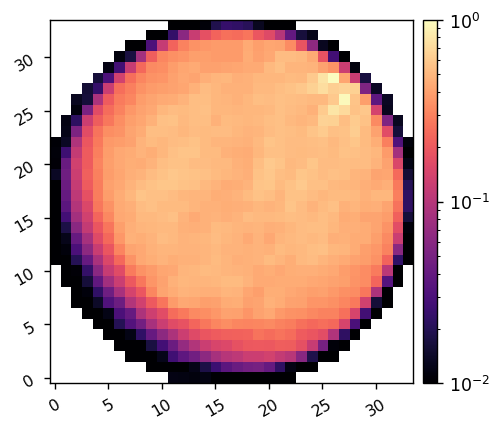

In [13]:
reload(lina.utils)
# response = lina.utils.map_acts_to_dm(xp.sqrt(((jac)**2).sum(axis=0)).get(), model.dm_mask)

responses = jac[::2] + 1j*jac[1::2]
dm_response = xp.sqrt(xp.mean(xp.abs(responses.dot(xp.array(calib_modes)))**2, axis=0)).reshape(model.Nact, model.Nact)
dm_response /= xp.max(dm_response)
imshow1(dm_response, lognorm=True, vmin=1e-2)

In [14]:
model.reset_dm()

images = xp.array([ref_im])
efields = xp.array([E_est])
commands = xp.array([model.get_dm()])

Beginning closed-loop EFC.
	Running iteration 34/36.
Using estimate_coherent_mod to estimate electric field


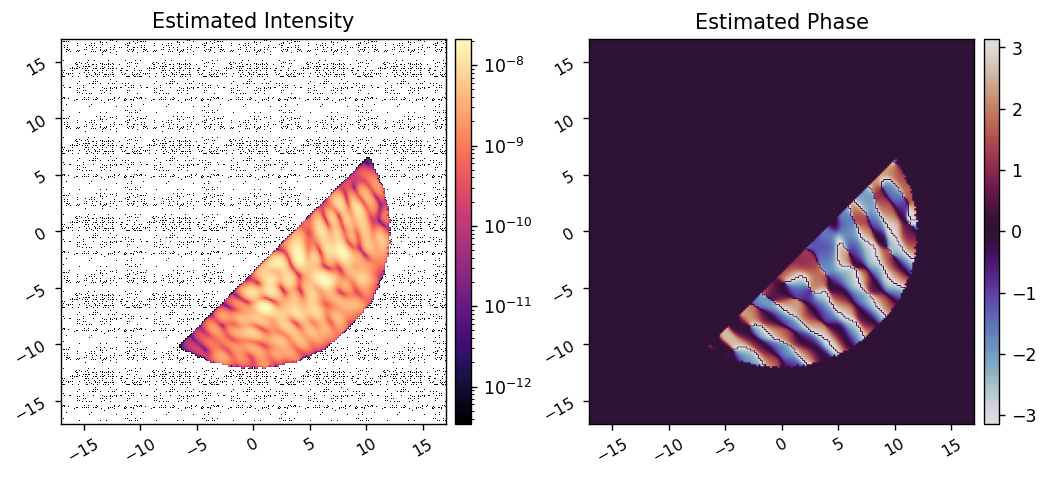

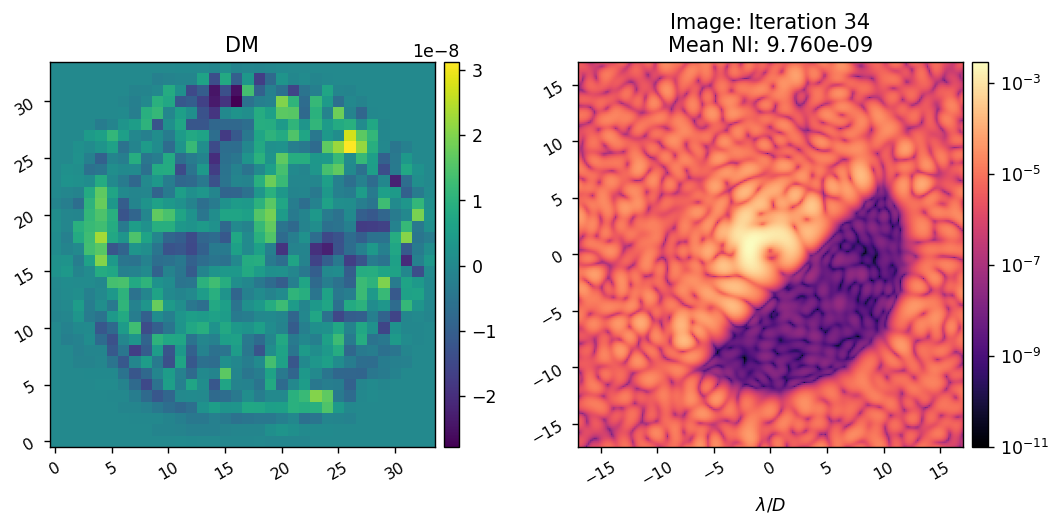

	Running iteration 35/36.
Using estimate_coherent_mod to estimate electric field


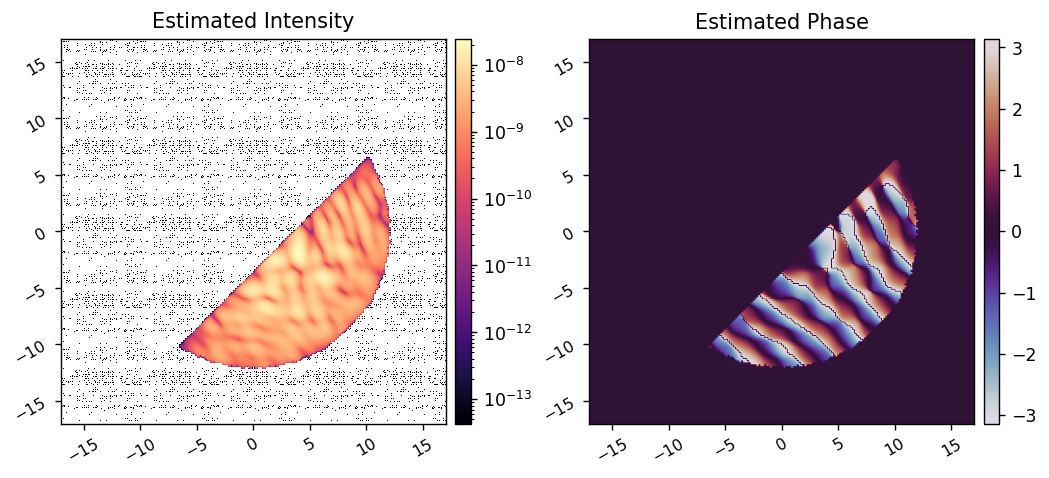

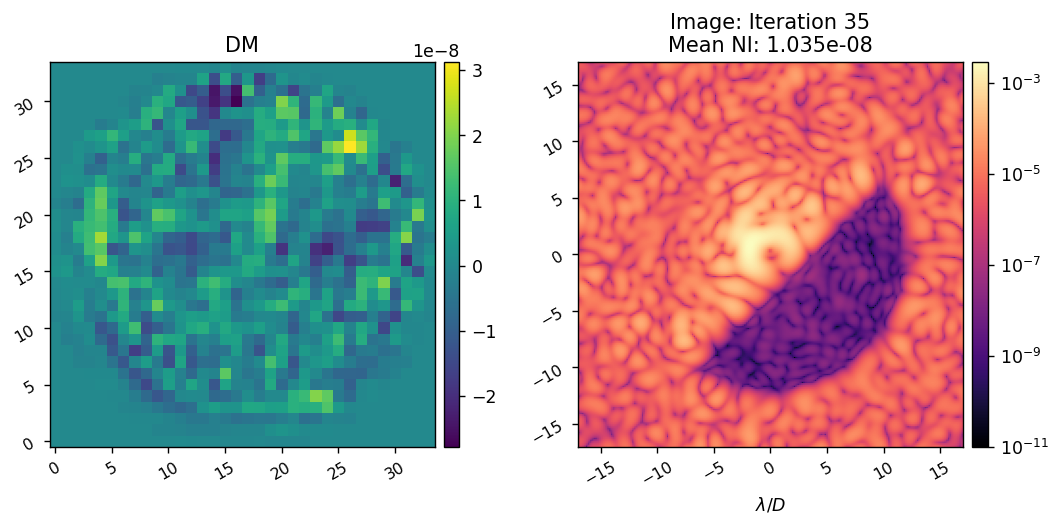

	Running iteration 36/36.
Using estimate_coherent_mod to estimate electric field


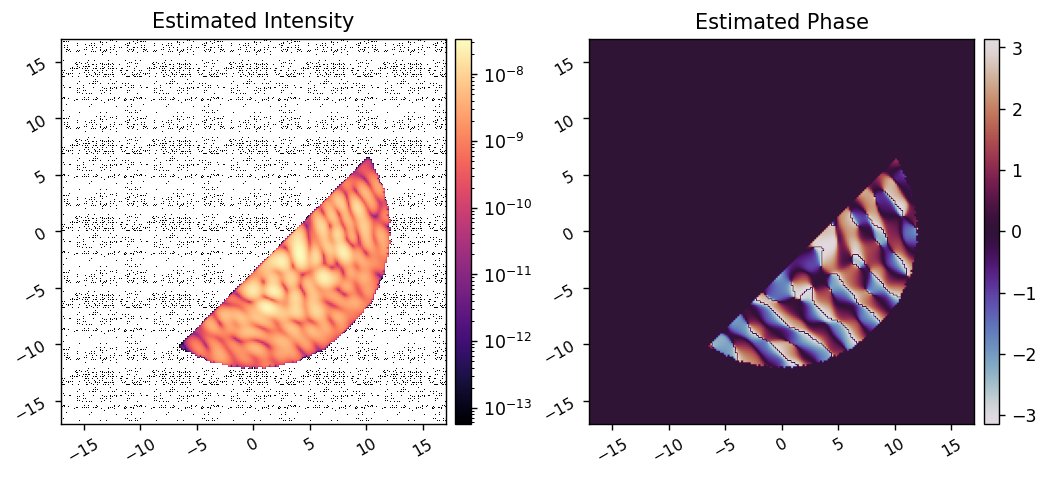

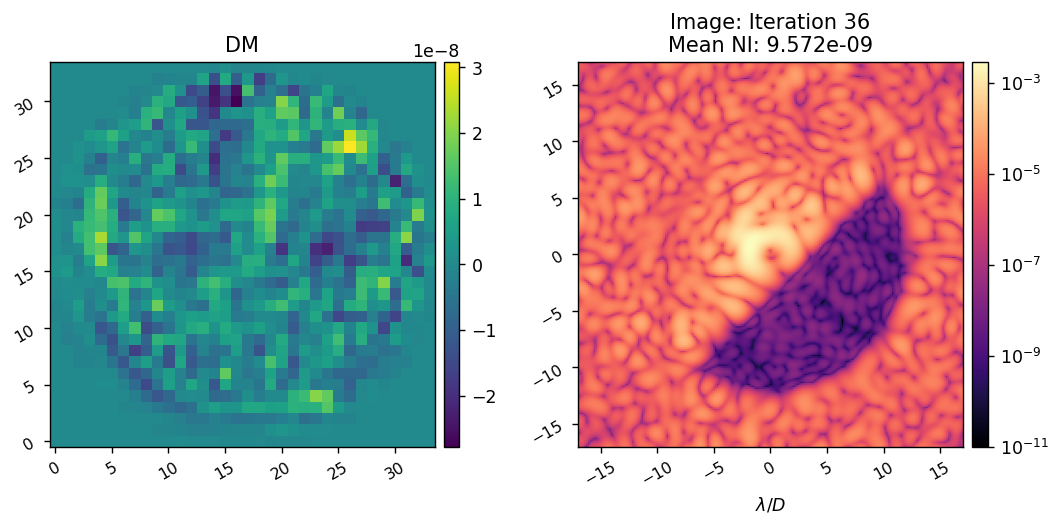

EFC completed in 3.789 sec.


In [26]:
reload(lina.efc)
reload(lina.scc)
control_matrix = lina.utils.beta_reg(jac, -2.5)
# control_matrix = lina.utils.beta_reg(jac, -4)
# control_matrix = lina.utils.beta_reg(jac, -4.5)
# control_matrix = lina.utils.beta_reg(jac, -5)
# control_matrix = lina.utils.beta_reg(jac, -6)

est_params.update({'scc_ref_image':None})
# est_params.update({'scc_ref_image':scc_ref_image})
est_params.update({'plot':False, 'plot_est':True})

images, efields, commands = lina.efc.run(model, 
                                         calib_modes,
                                        control_matrix,
                                        control_mask, 
                                        est_fun=est_fun, est_params=est_params,
                                        loop_gain=1, 
                                        leakage=0.0,
                                        iterations=3, 
                                        plot_all=True, 
                                        plot_radial_contrast=False,
                                        old_images=images,
                                        old_fields=efields,
                                        old_commands=commands,
                                        )

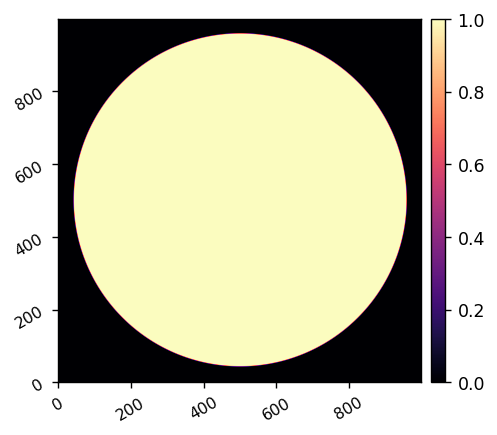

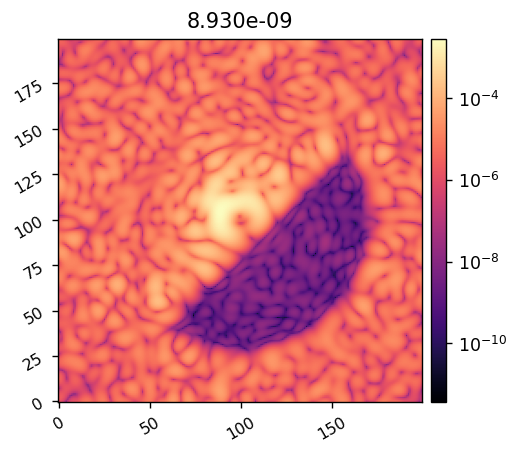

In [27]:
# model.scc_diam = 50*u.um
# model.use_scc()
model.use_scc(False)
imshow1(model.LYOT)

im = model.snap()
mean_contrast = xp.mean(im[control_mask])
imshow1(im, f'{mean_contrast:.3e}', lognorm=True)